In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
from movement import *
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'  # Ensure  background on plots is white

NU = 0.0001


def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        dt = Constant(P.timesteps[index])
        nu = Constant(NU)

        v = TestFunction(u.function_space())
        F = (
            inner((u - u_) / dt, v) * dx
            + inner(dot(u, nabla_grad(u)), v) * dx
            + nu * inner(grad(u), grad(v)) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)

        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])

        # Define form
        F = mesh_seq.form(index, {"u": (u, u_)})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"u": VectorFunctionSpace(mesh, "CG", 1), "f": FunctionSpace(mesh, "DG", 0)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(mesh_seq[0])
    # An initial condition that propagates to both ends
    return {"u": interpolate(as_vector([sin(pi * (x - 0.5)), 0]), fs)}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        # ds(2) is dy (ds, subdomain 2)
        return inner(u, u) * ds(2)

    return end_time_qoi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [6]:
n = 32
fields = ["u"]
mesh = UnitSquareMesh(n, n, diagonal='left')
# We use a pyroteus.MeshSeq even though we have only one mesh because it allows us to use MeshSeq.indicate_errors()
meshes = [mesh]
end_time = 0.5
dt = 1 / n
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=2
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

4 2


Text(0.5, 1.0, 'DWR Error indicators')

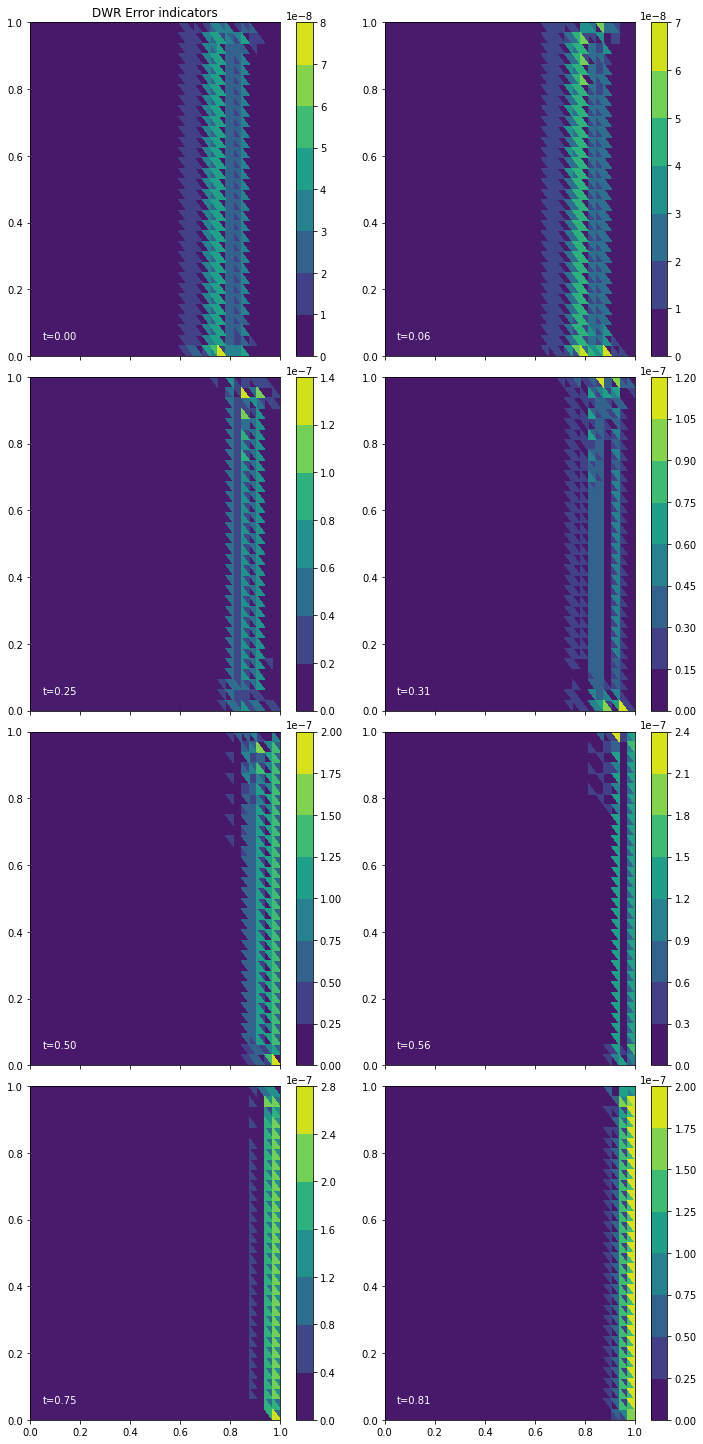

In [7]:
def plot_indicators(indicators, time_partition, **kwargs):
    """
    Plot a sequence of snapshots associated with
    ``indicators`` and :class:`TimePartition`
    ``time_partition``.

    Any keyword arguments are passed to ``tricontourf``.

    :arg indicators: list of list of indicators,
        indexed by mesh sequence index, then timestep
    :arg time_partition: the :class:`TimePartition`
        object used to solve the problem
    """
    P = time_partition
    rows = kwargs.pop('rows', (P.exports_per_subinterval[0] - 1) // 2)
    cols = kwargs.pop('cols', (P.num_subintervals * 2))
    steady = rows == cols == 1
    print(rows, cols)
    figsize = kwargs.pop("figsize", (6 * cols, 24 // cols))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(indicators[0][idx], axes=ax, **kwargs))
            if not steady:
                time = i * P.end_time/cols + j * P.timesteps_per_export[0] * P.timesteps[0]
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs


figsize = (10, 20)
fig, axs, tcs = plot_indicators(indicators, time_partition, figsize=figsize)
# print(len(axs), len(tcs), len(tcs[0]))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        fig.colorbar(tcs[i][j], ax=axs[i,j])
axs[0, 0].set_title("DWR Error indicators")
# axs.reshape((2, 2))

4 2


Text(0.5, 1.0, 'log DWR Errors')

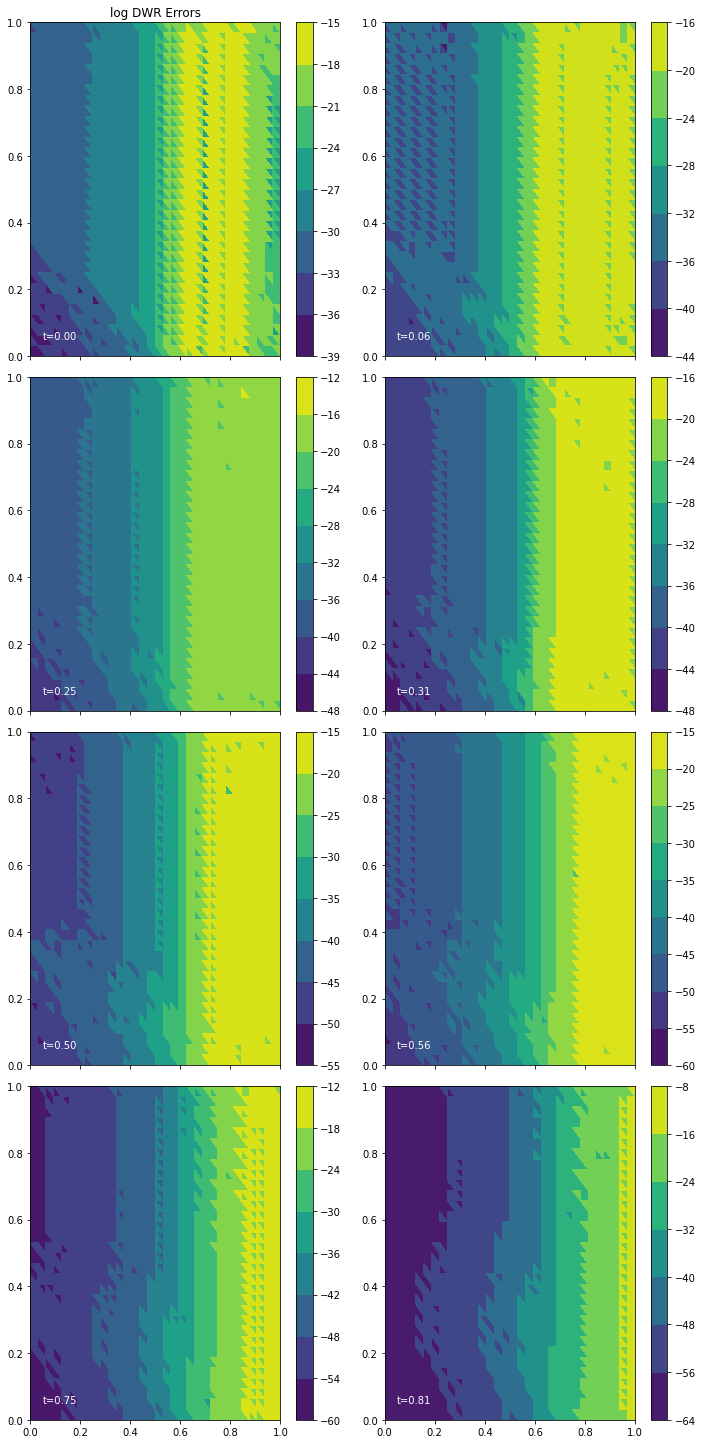

In [8]:
P0 = indicators[0][0].function_space()
log_indicators = [[Function(P0, val=np.log(indicators[0][i].dat.data)) for i in range(len(indicators[0]))]]
fig, axs, tcs = plot_indicators(log_indicators, time_partition, figsize=figsize)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        fig.colorbar(tcs[i][j], ax=axs[i, j])
axs[0][0].set_title("log DWR Errors")

## Normalizing the monitor function

In [9]:
def standardize(arr):
    normed = (arr - np.mean(arr)) / np.std(arr)
    normed -= np.min(normed)
    normed += 1
    return normed

def lp_normalize(arr, p=2):
    retval = arr**p
    denom = sum(retval)**(1/p)
    retval /= denom
    return retval

p = 1
standardized_indicators = []
normalized_indicators = []
for i in range(len(indicators)):
    t1 = []
    t2 = []
    for j in range(len(indicators[0])):
        t1.append(Function(P0, val=standardize(indicators[i][j].dat.data)))
        t2.append(Function(P0, val=lp_normalize(indicators[i][j].dat.data, p=p)))
    standardized_indicators.append(t1)
    normalized_indicators.append(t2)

4 2


Text(0.5, 1.0, 'Normalized DWR Errors (p=1)')

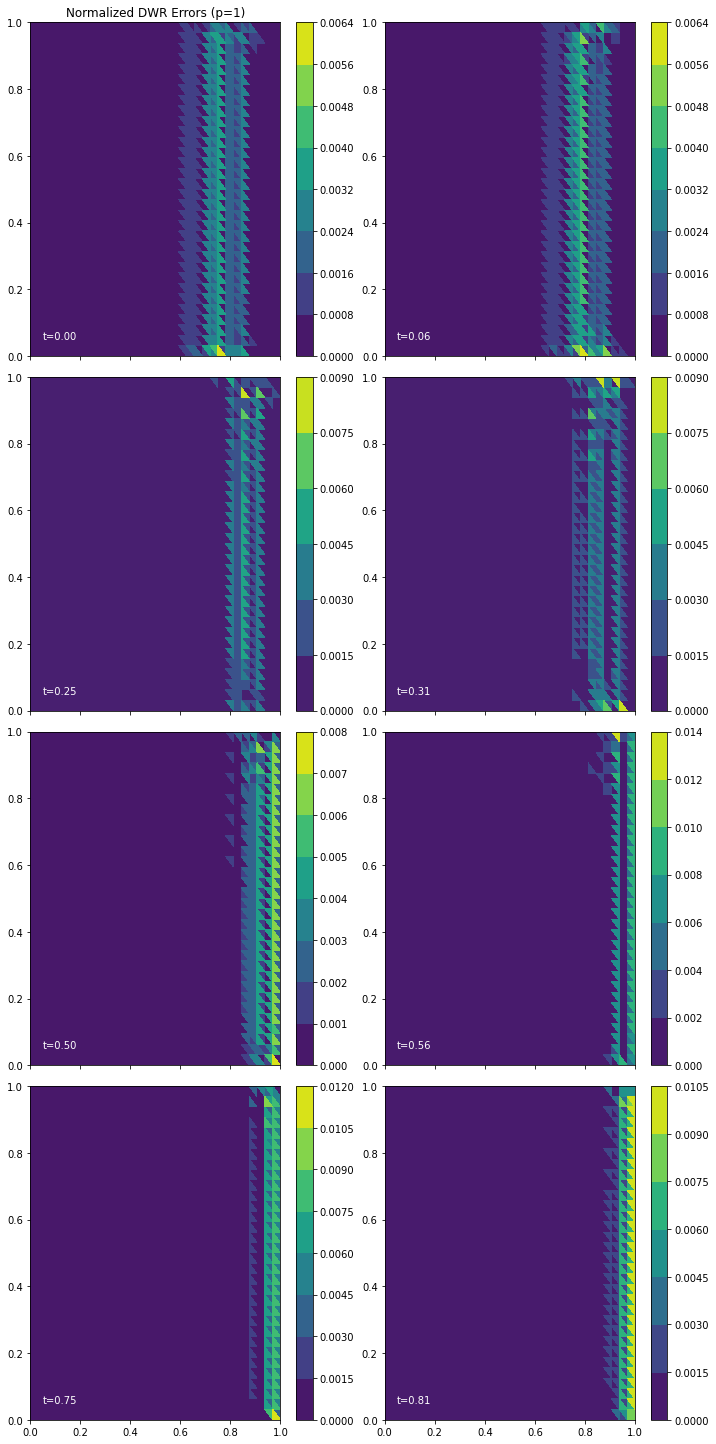

In [10]:
fig, axs, tcs = plot_indicators(normalized_indicators, time_partition, figsize=figsize)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        fig.colorbar(tcs[i][j], ax=axs[i, j])
axs[0][0].set_title("Normalized DWR Errors (p={})".format(p))

4 2


Text(0.5, 1.0, 'Standardized DWR Errors')

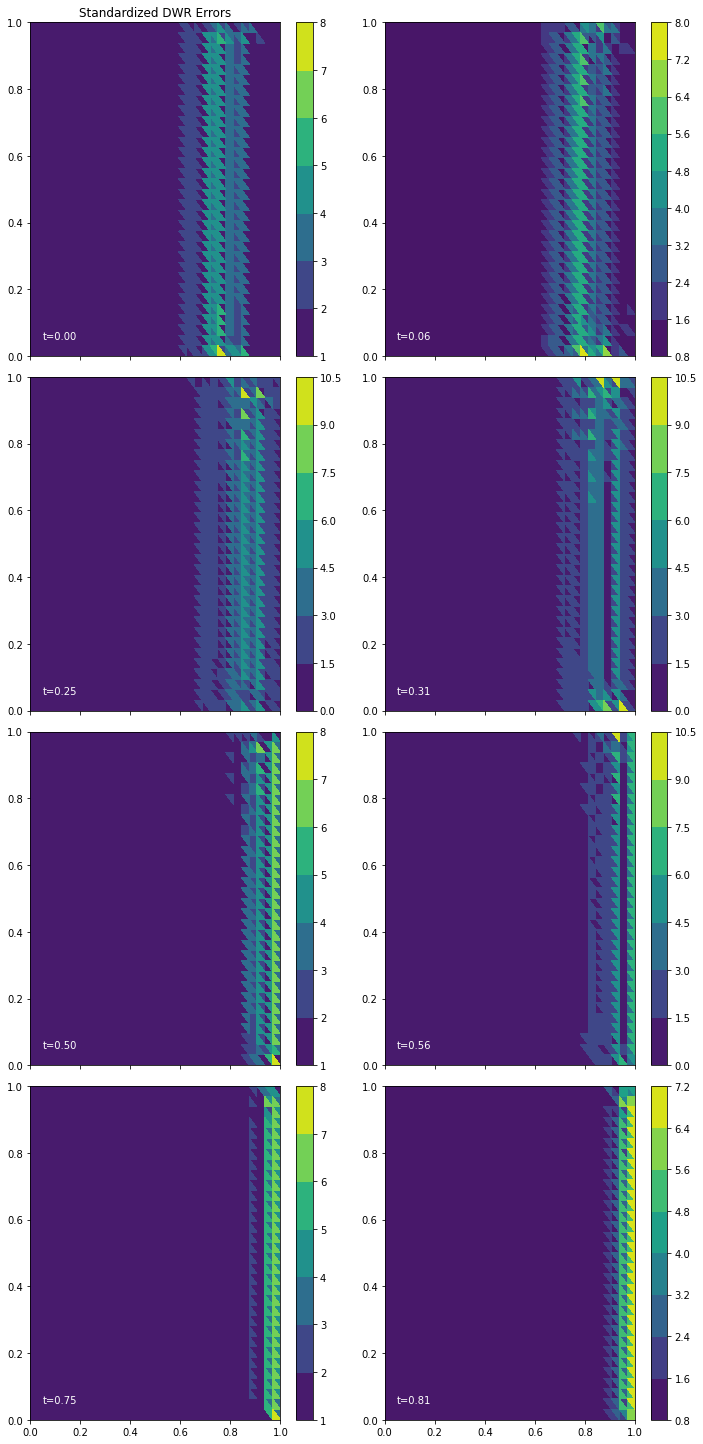

In [11]:
fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, figsize=figsize)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        fig.colorbar(tcs[i][j], ax=axs[i, j])
axs[0][0].set_title("Standardized DWR Errors")

In [12]:
meshes = [UnitSquareMesh(n, n, diagonal='left') for i in range(len(indicators[0]))]
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)

# print("Help?")

def get_get_monitor(mesh, i, indicators):
    def get_monitor(mesh):
        P0 = FunctionSpace(mesh, "DG", 0)
        f = Function(P0)
        f.project(indicators[0][i])
        return f
    return get_monitor

for i, mesh in enumerate(meshes):
    print("Working on mesh:{}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=1e-2)
    mover.move();
    print("Moved mesh {}".format(i))
#     if i < len(meshes) - 1:
#         meshes[i+1].coordinates.assign(mesh.coordinates)


Working on mesh:0
   0   Min/Max 1.8377e-01   Residual 5.9060e-01   Equidistribution 9.9734e-01
   1   Min/Max 2.5019e-01   Residual 3.2058e-01   Equidistribution 9.9840e-01
   2   Min/Max 4.4473e-01   Residual 2.1755e-01   Equidistribution 9.9862e-01
   3   Min/Max 4.0367e-01   Residual 1.3858e-01   Equidistribution 9.9875e-01
Converged in 3 iterations.
Moved mesh 0
Working on mesh:1
   0   Min/Max 1.6919e-01   Residual 5.7451e-01   Equidistribution 9.9712e-01
   1   Min/Max 2.9228e-01   Residual 3.5053e-01   Equidistribution 9.9820e-01
   2   Min/Max 4.1080e-01   Residual 2.3700e-01   Equidistribution 9.9858e-01
   3   Min/Max 4.9423e-01   Residual 1.2891e-01   Equidistribution 9.9880e-01
Converged in 3 iterations.
Moved mesh 1
Working on mesh:2
   0   Min/Max 1.9879e-01   Residual 6.0021e-01   Equidistribution 9.9754e-01
   1   Min/Max 2.3396e-01   Residual 3.6175e-01   Equidistribution 9.9815e-01
   2   Min/Max 3.3771e-01   Residual 2.1942e-01   Equidistribution 9.9861e-01
   3   M

Text(0.5, 0.98, 'Adapted meshes')

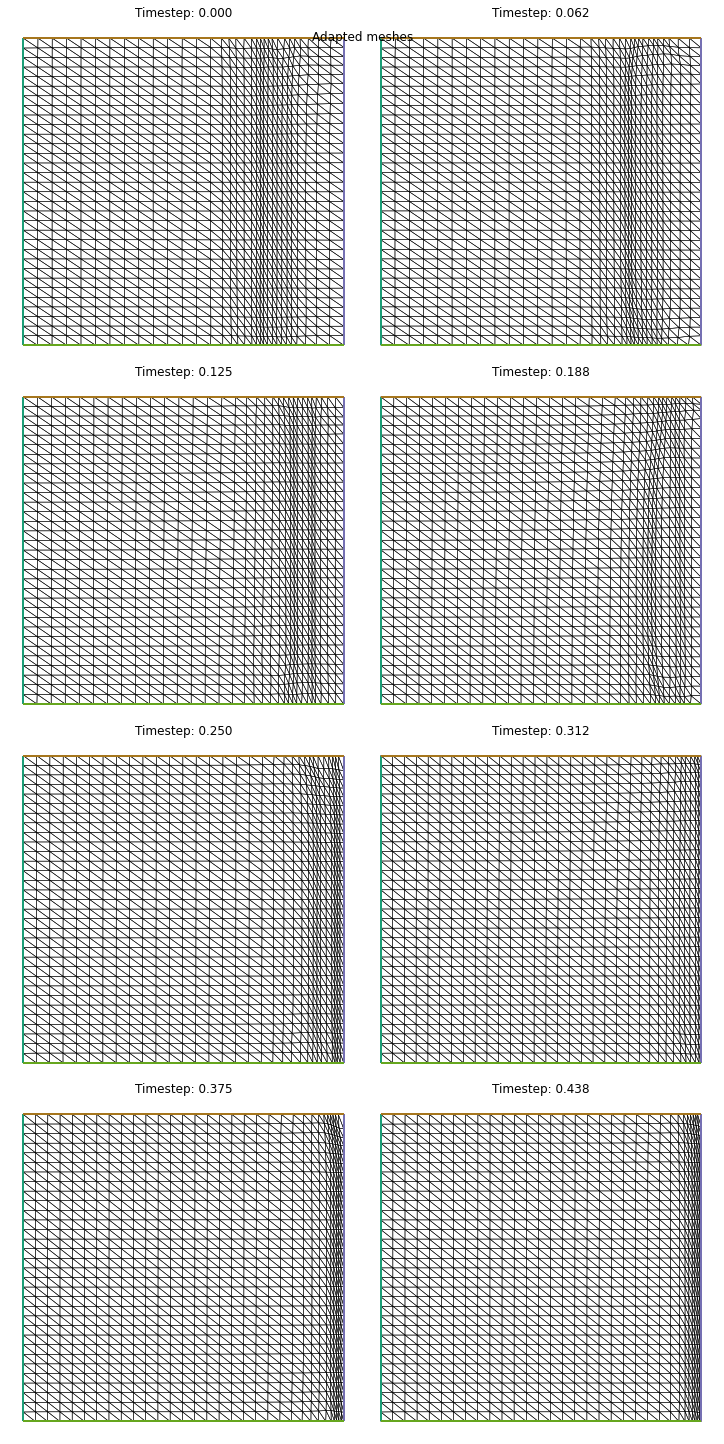

In [13]:
def plot_mesh(mesh, fig=None, axes=None, time_partition=None, **kwargs):
    kwargs.setdefault("interior_kw", {"linewidth": 0.5})
    kwargs.setdefault("boundary_kw", {"linewidth": 2.0})
    if fig is None and axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
    tp = triplot(mesh, axes=axes, **kwargs)
    axes.axis(False)
    return fig, axes, tp

fig, axs = plt.subplots(4, 2, figsize=figsize)
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes)// 4), i % 2
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = 2 * i * dt
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)
fig.tight_layout(pad=0.5)
plt.suptitle("Adapted meshes")

In [14]:
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

4 2


Text(0.5, 1.0, '(post-adaptation) DWR Error indicators')

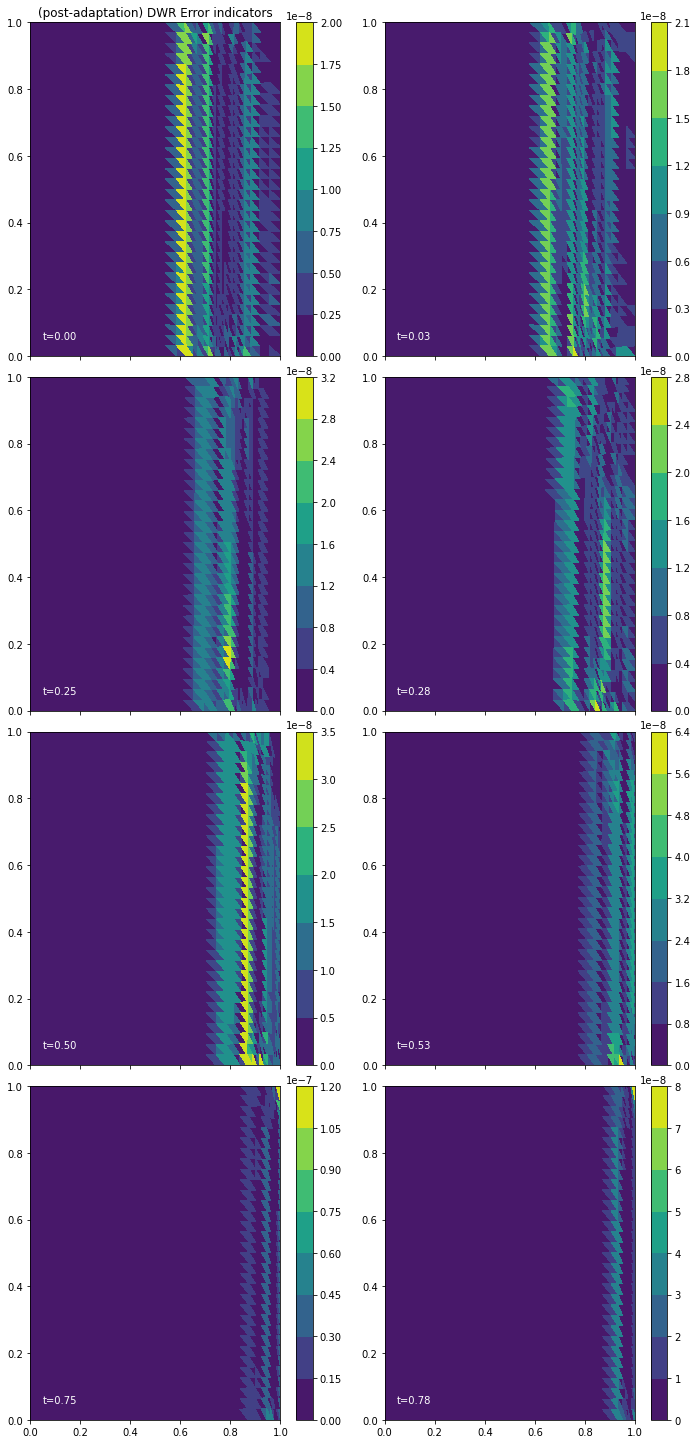

In [15]:
temp = [k[0] for k in indicators]
temp_indicators   =  [temp]
indicators = temp_indicators
fig, axs, tcs = plot_indicators(indicators, time_partition, figsize=figsize, rows=4, cols=2)
# print(len(axs), len(tcs), len(tcs[0]))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        fig.colorbar(tcs[i][j], ax=axs[i,j])
axs[0, 0].set_title("(post-adaptation) DWR Error indicators")

## Alternatively,  re-compute the  indicators after each movement iteration

In [ ]:
num_meshes = 8
meshes = [UnitSquareMesh(n, n, diagonal='left') for i in range(num_meshes)]

time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

In [ ]:
def reorder_indicators(indicators):
    temp = [k[0] for k in indicators]
    temp_indicators = [temp]
    return temp_indicators

def standardize_indicators(indicators, std_fn=standardize, **kwargs):
    retval = []
    for i in range(len(indicators)):
        t1 = []
        for j in range(len(indicators[0])):
            t1.append(Function(P0, val=std_fn(indicators[i][j].dat.data, **kwargs)))
        retval.append(t1)
    return retval

# print(len(indicators),  len(indicators[0]))

# print(len(indicators),  len(indicators[0]))

In [ ]:
def get_get_monitor(mesh, i, indicators):
    def get_monitor(mesh):
        P0 = FunctionSpace(mesh, "DG", 0)
        f = Function(P0)
        f.project(indicators[0][i])
        return f
    return get_monitor

def standardize_indicators(indicators, std_fn=standardize, **kwargs):
    retval = []
    for i in range(len(indicators)):
        t1 = []
        for j in range(len(indicators[0])):
            t1.append(Function(P0, val=std_fn(indicators[i][j].dat.data, **kwargs)))
        retval.append(t1)
    return retval

indicators = reorder_indicators(indicators)
standardized_indicators = standardize_indicators(indicators)
num_iter = 2
for it in range(num_iter):
    print("Iteration: {}".format(it))
    for i, mesh in enumerate(meshes):
        get_mon = get_get_monitor(mesh, i, standardized_indicators)
        mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=1e-1)
        mover.move();
        print("Moved mesh {}".format(i))
    print("------------------------Recomputing indicators------------------")
    solutions, indicators = mesh_seq.indicate_errors(
        enrichment_kwargs={"enrichment_method": "p"}
    )
    standardized_indicators = standardize_indicators(reorder_indicators(indicators))

KeyboardInterrupt: 

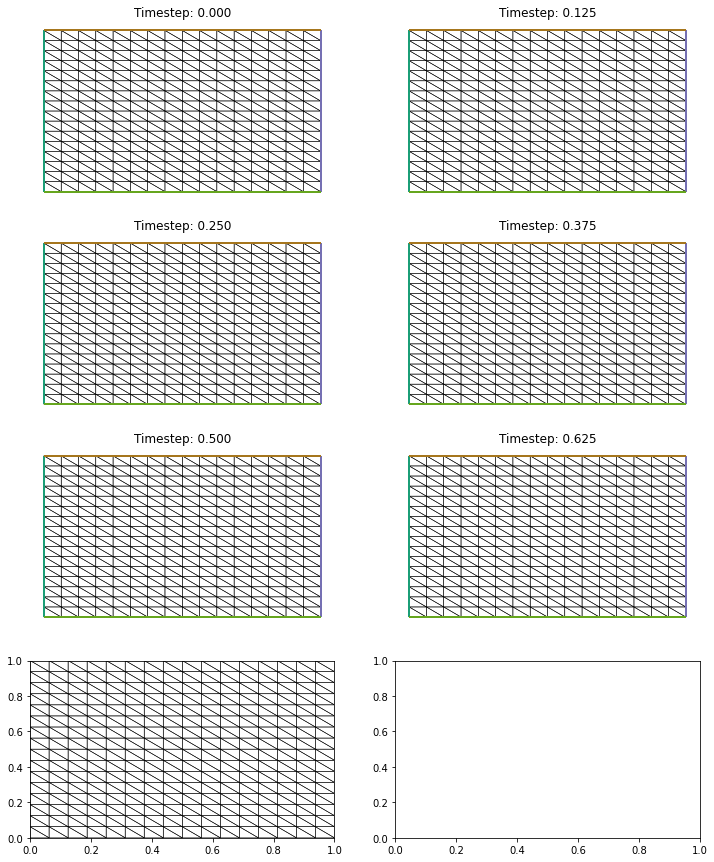

In [28]:
scale = 6
figsize = (2 * scale, int(2.5 * scale))
fig, axs = plt.subplots(4, 2, figsize=figsize)
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes)// 4), i % 2
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = 2 * i * dt
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)
plt.suptitle("Adapted meshes")